# **Exploring Model Graders for Reinforcement Fine-Tuning**

*This guide is for developers and ML practitioners who already know their way around OpenAIʼs APIs, have a basic understanding of reinforcement fine-tuning (RFT), and wish to use their fine-tuned models for research or other appropriate uses. OpenAI’s services are not intended for the personalized treatment or diagnosis of any medical condition and are subject to our [applicable terms](https://openai.com/policies/).*

[Reinforcement fine-tuning (RFT)](https://platform.openai.com/docs/guides/reinforcement-fine-tuning) of reasoning models consists in running reinforcement learning on of top the models to improve their reasoning performance by exploring the solution space and reinforcing strategies that result in a higher reward. RFT helps the model make sharper decisions and interpret context more effectively.


In this guide, weʼll walk through how to apply RFT to the OpenAI `o4-mini` reasoning model, using a task from the life sciences research domain: predicting outcomes from doctor-patient transcripts and descriptions, which is a necessary assessment in many health research studies. We'll use a subset of the medical-o1-verifiable-problem [dataset](https://huggingface.co/datasets/FreedomIntelligence/medical-o1-verifiable-problem/viewer/default/train?row=0). You will learn key steps to take in order to succesfully run RFT jobs for your use-cases.

Here’s what we’ll cover:

- **[1. Setup](#1-setup)**
- **[2. Gathering the dataset](#2-gathering-the-dataset)**
- **[3. Benchmarking the base model](#3-benchmarking-the-base-model)**
- **[4. Defining your grader](#4-defining-your-grader)**
- **[5. Training](#5-training)**
- **[6. Using your fine-tuned model](#6-using-your-fine-tuned-model)**

---


## **1. Setup**

Even strong reasoning models can miss the mark when it comes to expert-level behavior-especially in domains like medicine, where nuance and exactness matter. Imagine a model trying to extract [ICD-10](https://www.cms.gov/medicare/coding-billing/icd-10-codes) codes from a transcript: even if it understands the gist, it may not use the precise terminology expected by medical professionals.

Other great candidates for RFT include topics like ledger normalization or tiering fraud risk- settings in which you want precise, reliable, and repeatable reasoning. Checkout our [RFT use-cases guide](https://platform.openai.com/docs/guides/rft-use-cases) for great examples.

In our case, weʼll focus on teaching `o4-mini` to become better at predicting the outcomes of clinical conversations and descriptions. Specifically, we want to see if RFT can boost the accuracy of the prediction.

Along the way, weʼll talk about how to write effective graders, how they guide the modelʼs learning, and how to watch out for classic reward-hacking pitfalls.

In [1]:
!pip install -U datasets fsspec rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "


---


## **2. Gathering the Dataset**

Letʼs start off by loading the dataset from Hugging Face. Weʼre interested in samples framed as a description of a patient case with an associated question, followed by the correct answer. These represent real world transcripts where a physician is summarizing a case and assigning an outcome. For any use-case, verifying the accuracy of the gold level answers is critical and requires careful consideration. Here, we will trust the dataset quality.

In [2]:
import re
from datasets import load_dataset
ds = load_dataset("FreedomIntelligence/medical-o1-verifiable-problem")

def is_age_question(sample):
    question = sample.get('Open-ended Verifiable Question', '')
    # Match "A 88-year-old", "An 8-year-old", "A 23-year-old", etc. at the start
    return re.match(r"^(A|An) \d{1,2}-year-old", question) is not None

filtered_samples = [s for s in ds["train"] if is_age_question(s)]
print(f"Filtered samples: {len(filtered_samples)}")

README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

medical_o1_verifiable_problem.json:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40644 [00:00<?, ? examples/s]

Filtered samples: 9169


One of the advantages of RFT is that it doesnʼt need thousands of samples to start making a difference. Thanks to trajectory sampling and the feedback loop during training, the model learns not just correct behaviors, but also patterns to avoid. This means we can see solid gains even with small datasets.

For this run, weʼll randomly sample 100 training and 100 test examples and slightly normalize them.

In [3]:
import random

# Set a random seed for reproducibility
random.seed(42)

# Randomly select 100 training samples from filtered_samples
train_samples = random.sample(filtered_samples, min(100, len(filtered_samples)))

# Remove training samples from filtered_samples to avoid overlap
remaining_samples = [s for s in filtered_samples if s not in train_samples]

# Randomly select 100 test samples from the remaining samples (no overlap)
test_samples = random.sample(remaining_samples, min(100, len(remaining_samples)))

print(f"Number of training samples: {len(train_samples)}")
print(f"Number of test samples: {len(test_samples)}")

Number of training samples: 100
Number of test samples: 100


In [4]:
# Standardize the 'Ground-True Answer' fields to all lowercase in train and test samples
for sample in train_samples:
    if 'Ground-True Answer' in sample and isinstance(sample['Ground-True Answer'], str):
        sample['Ground-True Answer'] = sample['Ground-True Answer'].lower()

for sample in test_samples:
    if 'Ground-True Answer' in sample and isinstance(sample['Ground-True Answer'], str):
        sample['Ground-True Answer'] = sample['Ground-True Answer'].lower()


We'll convert these samples to `jsonl` format, as expected by the [reinforcement finetuning API](https://platform.openai.com/docs/api-reference/fine-tuning/reinforcement-input).

In [5]:
import json
import os

def convert_to_jsonl_format(samples, filename):
    with open(filename, "w") as f:
        for sample in samples:
            user_content = sample.get("Open-ended Verifiable Question", "")
            reference_answer = sample.get("Ground-True Answer", "")
            json_obj = {
                "messages": [
                    {"role": "user", "content": user_content}
                ],
                "reference_answer": reference_answer
            }
            f.write(json.dumps(json_obj) + "\n")

def load_jsonl(filename):
    samples = []
    with open(filename, "r") as f:
        for line in f:
            samples.append(json.loads(line))
    return samples

# Create the data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Save the datasets to jsonl files
convert_to_jsonl_format(train_samples, "data/medical_01_verifiable_problem_train.jsonl")
convert_to_jsonl_format(test_samples, "data/medical_01_verifiable_problem_val.jsonl")

# Load the datasets back from jsonl files
train_samples_loaded = load_jsonl("data/medical_01_verifiable_problem_train.jsonl")
test_samples_loaded = load_jsonl("data/medical_01_verifiable_problem_val.jsonl")


Next up: we’ll see how the base model performs out of the box-and where there’s room to grow.

---


## **3. Benchmarking the Base Model**

Before we fine-tune anything, we need to know where we’re starting from. Benchmarking gives us a clear picture of the model’s initial strengths and weaknesses-so we can later measure how far it’s come.

We’ll first lean on two simple yet powerful evaluators:

1. `clinical_phrase_binary_grader` - an exact-match checker.
2. `clinical_phrase_grader` - a softer, token-based similarity grader.

In [6]:
from rapidfuzz import fuzz, utils

def clinical_phrase_grader(sample: dict, item: dict) -> float:
    from rapidfuzz import fuzz, utils
    score = fuzz.token_set_ratio(sample["output_text"], item["reference_answer"], processor=utils.default_process)
    return score / 100.0

def clinical_phrase_binary_grader(sample: dict, item: dict) -> float:
    return 1.0 if sample["output_text"] == item["reference_answer"] else 0.0

def combined_grader(sample: dict, item: dict, weights: list[float] = [0.85, 0.15]) -> float:
    clinical_phrase_score = clinical_phrase_grader(sample, item)
    binary_score = clinical_phrase_binary_grader(sample, item)
    return weights[0] * clinical_phrase_score + weights[1] * binary_score

This combination lets us track both strict correctness and partial lexical overlap. The binary grader gives a crisp 0 or 1: did the model produce an exact match? The softer one gives more nuance-how close did the output come to the gold answer? We use both because outcomes are often phrased in multiple valid ways. For instance, a model might respond with “gouty arthritis” instead of “gout.” While a human evaluator could consider this partially acceptable, a strict string match would not. Combining exact and fuzzy scoring ensures a more accurate and fair assessment of model outputs.

We build a helper function to preprend the examples with a system prompt.

In [7]:
def prepend_system_prompt_to_first_user_message(samples, system_prompt, path=None):
    new_samples = []
    for sample in samples:
        # Deep copy to avoid mutating the original
        sample_copy = json.loads(json.dumps(sample))
        messages = sample_copy.get("messages", [])
        if messages and messages[0].get("role") == "user" and isinstance(messages[0].get("content"), str):
            if not messages[0]["content"].startswith(system_prompt):
                messages[0]["content"] = f"{system_prompt}\n\n{messages[0]['content']}"
        new_samples.append(sample_copy)
    if path is not None:
        with open(path, "w", encoding="utf-8") as f:
            for item in new_samples:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")
    return new_samples

In [8]:
simple_prompt = """You are an expert clinician. For each clinical vignette, respond with exactly one phrase: the single most likely outcome or phenomenon, all in lowercase.
- Do not add punctuation, articles, explanations, or commentary - output only the term itself.
- Sometimes, the expected answer can be a synonym of what you think.
- Use the standard clinical name (e.g. “thought withdrawal”, “Toxoplasma encephalitis”)."""
train_samples_loaded_simple_sys_prompt = prepend_system_prompt_to_first_user_message(
    train_samples_loaded, simple_prompt, path="data/medical_01_verifiable_problem_train_simple_prompt.jsonl"
)
test_samples_loaded_simple_sys_prompt = prepend_system_prompt_to_first_user_message(
    test_samples_loaded, simple_prompt, path="data/medical_01_verifiable_problem_val_simple_prompt.jsonl"
)

Then build a helper function to generate and store the model's predictions.

In [9]:
from google.colab import userdata
from openai import OpenAI

# Retrieve the API key from Colab secrets
API_KEY = userdata.get('OPENAI_API_KEY')

In [10]:
from openai import OpenAI
import concurrent.futures
from tqdm import tqdm
import os

client = OpenAI(api_key=API_KEY)

def generate_model_predictions(
    subset,
    prompt_type,
    model_name="o4-mini-2025-04-16",
    reasoning_effort="medium",
    n_runs=1,
    verbose=False,
):
    if isinstance(subset, str):
        samples_path = f"data/medical_01_verifiable_problem_{subset}_{prompt_type}_prompt.jsonl"
        with open(samples_path, "r", encoding="utf-8") as f:
            test_samples = [json.loads(line) for line in f if line.strip()]
    else:
        test_samples = [subset]

    def run_inference(item):
        resp = client.responses.create(
            model=model_name,
            input=item["messages"],
            reasoning={"effort": reasoning_effort, "summary": "detailed"},
        )
        model_prediction = {'output_text': resp.output_text}
        reasoning_tokens_used = resp.usage.output_tokens_details.reasoning_tokens
        summaries = [seg.text for item in resp.output if item.type == "reasoning" for seg in item.summary]
        summaries_string = "\n".join(summaries)
        if verbose:
            print("Prompt: {}".format(item["messages"][0]["content"]))
            print(f"Model Sample: {model_prediction}\nSolution: {item['reference_answer']}\n")
        return {
            "model_prediction": model_prediction["output_text"],
            "input": item,
            "reasoning_tokens_used": reasoning_tokens_used,
            "reference_answer": item["reference_answer"],
            "summaries": summaries_string
        }

    # Ensure the predictions directory exists before any file operations
    predictions_dir = os.path.join("data", "rft", "predictions")
    os.makedirs(predictions_dir, exist_ok=True)

    # Check if results already exist for all runs
    results_per_run = []
    for run_idx in range(n_runs):
        run_save_path = os.path.join(
            predictions_dir,
            f"{subset}_{prompt_type}_{model_name}_{reasoning_effort}_predictions_run{run_idx+1}.json"
        )
        if os.path.exists(run_save_path):
            print(f"Results for run {run_idx+1} already exist at {run_save_path}. Loading results.")
            with open(run_save_path, "r", encoding="utf-8") as f:
                run_results = json.load(f)
            results_per_run.append(run_results)
        else:
            if len(test_samples) == 1:
                run_results = [run_inference(test_samples[0])]
            else:
                run_results = []
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    futures = [executor.submit(run_inference, item) for item in test_samples]
                    for future in tqdm(futures, total=len(futures), desc=f"Generating predictions (run {run_idx+1})"):
                        result = future.result()
                        run_results.append(result)
                with open(run_save_path, "w", encoding="utf-8") as f:
                    json.dump(run_results, f, ensure_ascii=False, indent=2)
            results_per_run.append(run_results)

    # Return a flat list for backward compatibility
    if n_runs == 1:
        return results_per_run[0]
    else:
        return results_per_run

To generate the predictions, first make sure your API key is set:

```bash
export OPENAI_API_KEY=...
```

In [11]:
# OpenAI o4-mini model
results_simple_o4mini = generate_model_predictions(
    subset="train",
    prompt_type="simple",
    model_name="o4-mini",
    reasoning_effort="medium",
    n_runs=3
)

Generating predictions (run 3): 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


In [12]:
# OpenAI o3 model
results_simple_o3 = generate_model_predictions(
    subset="train",
    prompt_type="simple",
    model_name="o3",
    reasoning_effort="medium",
    n_runs=3
)

Generating predictions (run 3): 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


We now have predictions that are ready to be evaluated.<br>
We'll build a helper function that allows us to easily swap in different scoring methods,

In [13]:
import functools

def evaluate_predictions_with_grader(
    predictions,
    grader_func=combined_grader,
):
    results = []

    if isinstance(predictions, dict):
        predictions = [predictions]

    def run_grading(pred):
        model_prediction = {"output_text": pred["model_prediction"]}
        item = pred["input"]
        score = grader_func(model_prediction, item)
        result = pred.copy()
        result["score"] = score
        return result

    if len(predictions) == 1:
        result = run_grading(predictions[0])
        results.append(result)
    else:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(run_grading, pred) for pred in predictions]
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Grading predictions"):
                results.append(future.result())

    total = len(results)
    correct = sum(r["score"] for r in results)
    accuracy = correct / total if total else 0.0

    metrics = {
        "total_samples": total,
        "accuracy": accuracy,
    }
    print(metrics)
    return metrics, results

def run_prediction_evaluation(
    model_name="o4-mini",
    reasoning_effort="medium",
    prompt_type="simple",
    subset="train",
    grader_func=combined_grader,
    num_runs=3,
):
    if isinstance(grader_func, functools.partial):
        name = grader_func.func.__name__
        mg = grader_func.keywords["model_grader"]
        mg_name = mg["name"]
        name = f"{name}_{mg_name}"
    else:
        name = getattr(grader_func, "__name__", getattr(grader_func, "__class__", type(grader_func)).__name__)
    grader_func_name = name.replace(" ", "_").replace(":", "_").replace("/", "_").replace(",", "_")

    for i in range(num_runs):
        preds_path = f"data/rft/predictions/{subset}_{prompt_type}_{model_name}_{reasoning_effort}_predictions_run{i+1}.json"
        with open(preds_path, "r") as f:
            preds = json.load(f)
        metrics, results_with_scores = evaluate_predictions_with_grader(preds, grader_func=grader_func)
        # Save the scored results
        with open(f"data/rft/predictions/{subset}_{prompt_type}_{model_name}_{reasoning_effort}_{grader_func_name}_predictions_run_{i+1}_scored.json", "w") as f:
            json.dump(results_with_scores, f, indent=2)
        # Save the metrics
        with open(f"data/rft/predictions/{subset}_{prompt_type}_{model_name}_{reasoning_effort}_{grader_func_name}_predictions_run_{i+1}_metrics.json", "w") as f:
            json.dump(metrics, f, indent=2)
        # Save the scores (if present in results_with_scores)
        scores = [item.get("score") for item in results_with_scores if "score" in item]
        with open(f"data/rft/predictions/{subset}_{prompt_type}_{model_name}_{reasoning_effort}_{grader_func_name}_predictions_run_{i+1}_scores.json", "w") as f:
            json.dump(scores, f, indent=2)

def load_predictions(
    model_name="o4-mini",
    reasoning_effort="medium",
    prompt_type="simple",
    subset="train",
    grader_func_name="clinical_phrase_grader",
    num_runs=3
):
    all_predictions = []
    all_metrics = []
    for run in range(1, num_runs + 1):
        pred_path = f"data/rft/predictions/{subset}_{prompt_type}_{model_name}_{reasoning_effort}_{grader_func_name}_predictions_run_{run}_scored.json"
        metrics_path = f"data/rft/predictions/{subset}_{prompt_type}_{model_name}_{reasoning_effort}_{grader_func_name}_predictions_run_{run}_metrics.json"
        try:
            with open(pred_path, "r") as f:
                predictions = json.load(f)
        except FileNotFoundError:
            predictions = None
        try:
            with open(metrics_path, "r") as f:
                metrics = json.load(f)
        except FileNotFoundError:
            metrics = None
        all_predictions.append(predictions)
        all_metrics.append(metrics)
    return all_predictions, all_metrics

and then run the evaluations.

In [14]:
model_name = "o4-mini"
reasoning_effort = "medium"
prompt_type = "simple"
subset = "train"
grader_func = combined_grader
grader_func_name = "combined_grader"
num_runs = 3
run_prediction_evaluation(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func=grader_func,
    num_runs=num_runs
)
predictions_o4mini_medium_simple_prompt, metrics_o4mini_medium_simple_prompt = load_predictions(model_name=model_name, reasoning_effort=reasoning_effort, prompt_type=prompt_type, subset=subset, grader_func_name=grader_func_name, num_runs=num_runs)

Grading predictions: 100%|██████████| 100/100 [00:00<00:00, 159055.90it/s]


{'total_samples': 100, 'accuracy': 0.5589137423841866}


Grading predictions: 100%|██████████| 100/100 [00:00<00:00, 150225.79it/s]


{'total_samples': 100, 'accuracy': 0.5769471951835046}


Grading predictions: 100%|██████████| 100/100 [00:00<00:00, 179550.68it/s]

{'total_samples': 100, 'accuracy': 0.5898894802398068}


Visualizing the results allows us to spot trends and failure modes.

In [15]:
# Print mistakes where the model did not get the correct answer (score < 1.0)
mistakes = [
    {"index": i, **res}
    for i, res in enumerate(predictions_o4mini_medium_simple_prompt[0])
    if res["score"] < 1.0
]

print(f"\nTotal mistakes: {len(mistakes)}")
for m in mistakes[15:20]:
    print(f"\n[Sample {m['index']}]")
    print(f"  Model prediction: {m['model_prediction']}")
    print(f"  Reference answer: {m['reference_answer']}")
    print(f"  Score: {m['score']}")


Total mistakes: 87

[Sample 15]
  Model prediction: thyroid stimulating hormone level
  Reference answer: serum tsh levels
  Score: 0.38163265306122446

[Sample 16]
  Model prediction: amniocentesis
  Reference answer: confirmatory amniocentesis and chromosomal analysis of the fetal cells
  Score: 0.85

[Sample 17]
  Model prediction: nifedipine
  Reference answer: magnesium sulfate + betamethasone
  Score: 0.1658536585365854

[Sample 18]
  Model prediction: 46 xx gonadal dysgenesis
  Reference answer: gonadal dysgenesis
  Score: 0.85

[Sample 19]
  Model prediction: type ii hypersensitivity
  Reference answer: type ii–cytotoxic hypersensitivity reaction
  Score: 0.85


As observed above, typical failure modes fall into three categories:
1. Small differences and formatting issues, score >=0.8.
2. Partial lexical match, 0.3 < score < 0.8.
3. Lexically off-base, score < 0.3.

We can visualize the full score distribution on the training set.

> Note: In practice, analyzing model errors at scale often involves a mix of manual review and automated methods-like tagging failure types or clustering predictions by score and content. That workflow is beyond the scope of this guide, but it's a valuable next step once you've identified broad patterns.

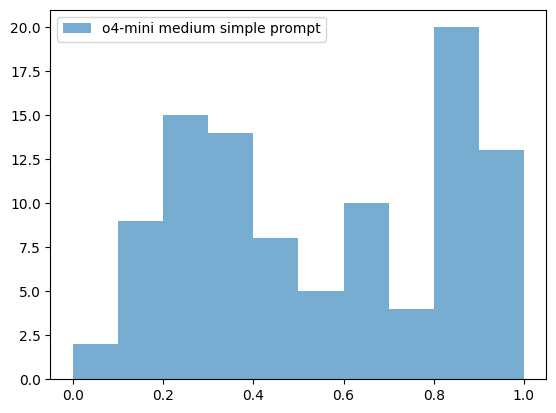

In [16]:
import matplotlib.pyplot as plt
scores_distribution = [m['score'] for m in predictions_o4mini_medium_simple_prompt[0]]
plt.hist(scores_distribution, alpha=0.6, label='o4-mini medium simple prompt')
plt.legend()

Let's compare with other models and prompts, and visualize scores.

In [17]:
# OpenAI o3 model
model_name = "o3"
reasoning_effort = "medium"
prompt_type = "simple"
subset = "train"
grader_func = combined_grader
grader_func_name = "combined_grader"
num_runs = 3
run_prediction_evaluation(model_name=model_name, reasoning_effort=reasoning_effort, prompt_type=prompt_type, subset=subset, grader_func=grader_func, num_runs=num_runs)
predictions_o3_medium_simple_prompt, metrics_o3_medium_simple_prompt = load_predictions(model_name=model_name, reasoning_effort=reasoning_effort, prompt_type=prompt_type, subset=subset, grader_func_name=grader_func_name, num_runs=num_runs)

Grading predictions: 100%|██████████| 100/100 [00:00<00:00, 158754.88it/s]


{'total_samples': 100, 'accuracy': 0.6191175117243966}


Grading predictions: 100%|██████████| 100/100 [00:00<00:00, 189530.23it/s]


{'total_samples': 100, 'accuracy': 0.6193015279556342}


Grading predictions: 100%|██████████| 100/100 [00:00<00:00, 186828.69it/s]

{'total_samples': 100, 'accuracy': 0.6184123091661671}


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

def average_and_std_metrics(metrics_list):
    """Returns dicts of mean and std for a list of metrics dicts."""
    if not metrics_list: return {}, {}
    keys = metrics_list[0].keys()
    arr = {k: np.array([m[k] for m in metrics_list]) for k in keys}
    mean = {k: float(np.mean(arr[k])) for k in keys}
    std = {k: float(np.std(arr[k])) for k in keys}
    return mean, std

def plot_model_accuracies(model_metrics_avg, model_metrics_std, grader_title="Combined Grader Accuracy", sharey: bool = True) -> None:
    """Plots model accuracies with standard deviation error bars."""
    # Convert the nested dicts into tidy DataFrames
    df_avg = pd.DataFrame(model_metrics_avg).T.reset_index().rename(columns={"index": "Model"})
    df_std = pd.DataFrame(model_metrics_std).T.reset_index().rename(columns={"index": "Model"})

    # Long-form for Seaborn
    long_df_avg = df_avg.melt(id_vars="Model", value_vars=["accuracy"], var_name="Metric", value_name="Accuracy")
    long_df_std = df_std.melt(id_vars="Model", value_vars=["accuracy"], var_name="Metric", value_name="Std")

    # Merge avg and std for error bars
    long_df = pd.merge(long_df_avg, long_df_std, on=["Model", "Metric"])

    pretty_names = {"accuracy": grader_title}

    # Create a separate figure for each metric
    for metric_key in ["accuracy"]:
        metric_df = long_df[long_df["Metric"] == metric_key].copy()
        plt.figure(figsize=(8, 5))
        # Plot bars with error bars
        ax = sns.barplot(data=metric_df, x="Model", y="Accuracy", hue="Model", palette="tab10", legend=False, errorbar=None)
        bars = ax.patches
        # Add error bars manually
        for i, row in enumerate(metric_df.itertuples()):
            bar = bars[i]
            x = bar.get_x() + bar.get_width() / 2
            y = row.Accuracy
            yerr = row.Std
            ax.errorbar(x=x, y=y, yerr=yerr, fmt='none', ecolor='black', capsize=5, elinewidth=2, capthick=2, zorder=10)
        plt.title(pretty_names[metric_key])
        plt.ylabel("Accuracy")
        plt.xlabel("")
        if sharey: plt.ylim(0, 1)
        # Annotate bars with exact values
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 6), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')
        plt.xticks(rotation=15, ha="right")
        plt.tight_layout()
        plt.show()

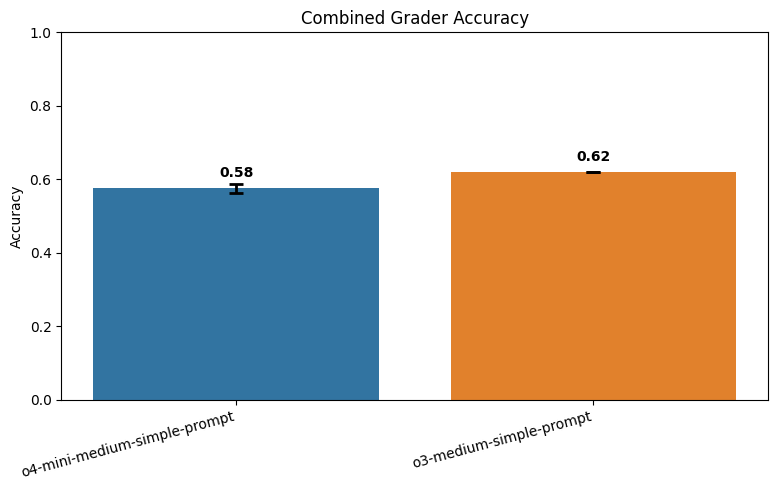

In [19]:
avg_metrics_o4mini_medium_simple_prompt, std_metrics_o4mini_medium_simple_prompt = average_and_std_metrics(metrics_o4mini_medium_simple_prompt)
avg_metrics_o3_medium_simple_prompt, std_metrics_o3_medium_simple_prompt = average_and_std_metrics(metrics_o3_medium_simple_prompt)
model_metrics_avg = {
    "o4-mini-medium-simple-prompt": avg_metrics_o4mini_medium_simple_prompt,
    "o3-medium-simple-prompt": avg_metrics_o3_medium_simple_prompt,
}
model_metrics_std = {
    "o4-mini-medium-simple-prompt": std_metrics_o4mini_medium_simple_prompt,
    "o3-medium-simple-prompt": std_metrics_o3_medium_simple_prompt,
}
plot_model_accuracies(model_metrics_avg, model_metrics_std, grader_title="Combined Grader Accuracy")

We can see that the modelʼs performance has clear limits. In practice, iterating on the prompt often helps boost baseline results and get more out of the base model. However, in this case, our prompt engineering didnʼt lead to meaningful improvements-so we excluded those runs from the analysis.


A key requirement for RFT to work is that the base model demonstrates it can successfully complete the task for at least some examples right out of the gate. The initial accuracy of ~0.6 is a strong signal that RFT can boost performance. If the model never succeeds on your tasks, there is no training signal to hill climb on.


This evaluation process prepares us for the next step: guiding the model with structured, high-quality feedback from a grader.

---


## **4. Defining Your Grader**

The grader defines the reward function that shapes model behavior during RFT. It provides examples of desired outputs-and penalizes undesirable ones. Designing an effective grader requires both principled structure and thoughtful domain insight, and is perhaps the most important task for successful RFT.

In this section, we will present 3 graders, show how they should be set up to fit the API, and discuss the results they yielded. We will then show how to actually launch an RFT task.

### String based grader
We began with a dual grader using our earlier evaluation functions since it provides a distribution of scores that will be aligned with the lexical proximity of the prediction to the reference answer. It provided a starting point, but the signal wasnʼt rich enough for `o4-mini` to truly learn and improve, and a first experiment showed stagnant reward during the RFT run. For the API calls, you should build the python grading function as shown below.

In [21]:
import inspect

# --- Utility functions ---
def build_python_grader_payload(grader_fn) :
    """Build a payload for a python grader."""
    grader_source = inspect.getsource(grader_fn)
    # Enforce function name to be `grade`
    grader_source = grader_source.replace(grader_fn.__name__, "grade", 1)
    return {
        "type": "python",
        "source": grader_source,
    }

multi_python_grader_tool_call = {
    "type": "multi",
    "graders": {
        "clinical_phrase": {
            "name": "clinical_phrase_grader",
            "image_tag": "2025-05-08",
            **build_python_grader_payload(clinical_phrase_grader),
        },
        "clinical_phrase_binary": {
            "name": "clinical_phrase_binary_grader",
            "image_tag": "2025-05-08",
            **build_python_grader_payload(clinical_phrase_binary_grader),
        },
    },
    "calculate_output": "0.85 * clinical_phrase + 0.15 * clinical_phrase_binary",
}

Here is a snapshot of its training curves, where the green curve is the traning set reward and the blue curve is the test set reward:

![RFT String Grader](https://github.com/chauhang/openai-cookbook/blob/main/images/rft_string_grader.png?raw=1)

### Model Grader 1
To address this limitation, we introduced a more advanced approach: the **model grader**. A model-based grader lets us embed semantic understanding and nuance into the feedback. Thatʼs especially powerful when domain-specific synonyms or fuzzy reasoning are in play.

We used gpt-4.1 as our grader model, guided by a rubric that emphasized semantic fidelity: clinical synonymy, correct disease categorization, and conceptual alignment. Rather than focusing on superficial phrasing-e.g., "Is this the same string?"-the grader aimed to answer, "Does this reflect the correct outcome or phenomenon?"

To ensure the grader aligned with expert expectations, we evaluated it on a subset of base model predictions. For any production use-case, domain expert reviewers should verify that model assigned scores reflect preferred answer orderings and align with domain judgment. This typically involves confirming that the model grader correctly ranks predictions according to their validity. In the scope of this cookbook, we approximated this evaluation by using OpenAI `o3` to check whether higher-quality predictions were consistently rewarded relative to their alternatives.

From these discussions of `o3` , we iteratively update the model grader until the results are aligned.

In [22]:
GRADER_PROMPT_1 = """
System:
  You are an expert medical grader. Compare the **Reference Answer** to the **Model's Answer** and produce **only** a JSON object with:
    • **result**: a float between 0.0 and 1.0
    • **steps**: a list of reasoning steps (each with a `"description"` and a `"conclusion"`)

  Scoring rubric (start at 0.0, then add or subtract):
    1. Exact lexical match: **+0.15**
    2. Clinical synonym (e.g. “withdrawal of thought” ↔ “thought withdrawal”): **+0.35**
    3. Same disease family (e.g. two viral encephalitides): **+0.35**
    4. Partial term overlap (e.g. “ulcer” in both phrases): **+0.15**
    5. Completely unrelated: **-0.10**

  • If multiple criteria apply, sum their weights (max 1.0).
  • Cap the final score to the [0.0, 1.0] range.
  • In your **steps**, show which rule you applied and the running subtotal.
"""

To be submitted through the API, this is how the dictionary is built.

In [23]:
model_grader_1 = {
   "type": "score_model",
   "name": "gpt41_score_model_1",
   "input": [
        {
            "role": "system",
            "content": GRADER_PROMPT_1
        },
        {
            "role": "user",
            "content": "Reference Answer: {{item.reference_answer}}. Model's Answer: {{sample.output_text}}"
        }
   ],
   "pass_threshold": 0.75,
   "model": "gpt-4.1-2025-04-14",
   "range": [0, 1],
   "sampling_params": {
       "seed": 42,
       "temperature": 0,
   },
}

Accordingly, we set up the model grader locally to check the results of the models we will fine-tune next.

In [24]:

from pydantic import BaseModel
from typing import List

class GraderStep(BaseModel):
    description: str
    conclusion: str

class GraderResponse(BaseModel):
    result: float
    steps: List[GraderStep]

# Adapted python_model_grader to match the other graders' interface
def python_model_grader(sample, item, model_grader=model_grader_1):
    """
    Calls an OpenAI model to grade the model output against the reference answer.
    Expects sample to have "output_text", item to have "reference_answer".
    Returns a float score (parsed from the model's JSON response).
    """
    # Prepare the prompt as the grader expects
    system_prompt = model_grader["input"][0]["content"]
    user_prompt = model_grader["input"][1]["content"]
    user_prompt_filled = user_prompt.replace("{{item.reference_answer}}", item["reference_answer"]).replace("{{sample.output_text}}", sample["output_text"])
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt_filled}
    ]
    # Call the OpenAI API with the grader's model
    response = client.beta.chat.completions.parse(
        model=model_grader["model"],
        messages=messages,
        seed=model_grader.get("sampling_params", {}).get("seed", None),
        temperature=model_grader.get("sampling_params", {}).get("temperature", 0),
        response_format=GraderResponse,
    )
    # Parse the float score from the model's JSON response
    parsed = response.choices[0].message.parsed
    if not isinstance(parsed, GraderResponse):
        raise RuntimeError(f"Grader returned invalid structured output: {parsed!r}")
    return float(parsed.result)

While the rubric initially delivered sensible feedback, the model soon uncovered a loophole and began **reward-hacking**. Scores shot up-sometimes by 20-30 percentage points-not because clinical accuracy improved but because the model padded its “one phrase” answers with synonyms, doses, and full management plans. You might see `begin warfarin therapy **and** continue unfractionated heparin for ≥5 days, overlapping until the INR is in the therapeutic range (2–3)` or `chewable aspirin 325 mg stat plus nitroglycerin…` instead of the required `continue unfractionated heparin` or `aspirin` respectively. Although the system prompt is explicit-*“respond with exactly one phrase: the single most likely outcome or phenomenon”*-these verbose outputs inflate *lexical_similarity* scores without precisely adding prediction value. This experience highlights the need to continuously inspect model outputs and remain vigilant for reward-hacking behaviours that can quietly distort evaluation metrics.

Here is a snapshot of its training curves (green is training reward, blue is test reward):

![RFT Model Hacking](https://github.com/chauhang/openai-cookbook/blob/main/images/rft_hacking.png?raw=1)

### Model Grader 2
To mitigate this reward-hack, we refined the grader prompt by clarifying expectations, enforcing stricter output constraints, and supplying contrastive examples of correct versus incorrect behavior. Once again, we've iterated with `o3`, leveraging predictions from the base `o4-mini` and the previous fine-tuned model hacking examples, to design and validate our grader. Another important point of this updated grader is the reduction of the weight of the *lexical_similarity*, to ensure that *clinical_similarity* prevails.

In [25]:
GRADER_PROMPT_2 = """You are an expert medical grader.

Compare the reference_answer (gold standard) with the model_prediction
and return **exactly** this JSON object:

{
  "steps": [            // each: {"description": "...", "conclusion": "..."}
    …
  ],
  "result": <float 0-1 rounded to 3 decimals>
}

──────────────── Input placeholders ───────────────
reference_answer:
model_prediction:

──────────── Normalisation steps ────────────
• lowercase, strip punctuation / excess whitespace
• expand common abbreviations (e.g. cll → chronic lymphocytic leukemia)
• map both strings to ICD-10 / SNOMED concepts when possible

──────────── Clinical layer rubric ───────────
L1  exact concept or universally accepted synonym
L2  same concept but benign modifier differs (e.g. “acute”, “left”)
L3  same disease / drug family but wrong subtype or variant
L4  same organ system but entirely different disease / intervention
L5  only partial mechanistic overlap (e.g. both vasodilators)
L6  unrelated or nonsensical

──────────── Scoring parameters ─────────────
clinical_weight  = 0.90
lexical_weight   = 0.10
clinical_similarity = {1:1.00, 2:0.85, 3:0.45, 4:0.30, 5:0.10, 6:0.00}

lexical_similarity = normalized_levenshtein(reference_answer,
                                            model_prediction)

# Optional penalty if a clinically critical adjective is missing
critical_modifiers = [
  "wide", "narrow", "acute", "chronic", "posteromedial",
  "oxidized", "oxidised", "left", "right"
]
modifier_pen = -0.05 if any(
    w in reference_answer and w not in model_prediction
    for w in critical_modifiers
) else 0.0

# Determine layer L (1-6) per rubric above using ontology + judgment.
if L == 6:
    score = 0.0
else:
    score = (clinical_weight * clinical_similarity[L] +
             lexical_weight  * lexical_similarity) + modifier_pen

Clamp to [0,1] and round to 3 decimals.
Output **only** the JSON.

──────────────── Worked examples ─────────────
reference_answer: beta-thalassemia major
model_prediction: beta-thalassemia minor
reasoning: Both involve β-globin chain synthesis, but “major” causes
          transfusion-dependent anemia while “minor” is largely benign;
          same family, wrong subtype → **L3**. Lexical ≈ 0.83.
score = 0.90·0.45 + 0.10·0.83 = 0.488 → **0.488**

reference_answer: ACE inhibitor
model_prediction: angiotensin-receptor blocker
reasoning: Both act on the renin–angiotensin axis yet on different
          targets; only partial mechanistic overlap → **L5**.
          Lexical ≈ 0.31.
score = 0.90·0.10 + 0.10·0.31 = 0.121 → **0.121**

reference_answer: acute pancreatitis
model_prediction: pancreatitis
reasoning: Same disorder but missing timing adjective “acute”;
          benign modifier difference → **L2**. Lexical ≈ 0.78.
score = 0.90·0.85 + 0.10·0.78 = 0.843 → **0.843**

reference_answer: valproate
model_prediction: valproic acid
reasoning: Valproic acid is the active moiety of valproate; mechanisms
          and indications are identical → **L1**. Lexical ≈ 0.82.
score = 0.90·1.00 + 0.10·0.82 = 0.982 → **0.982**

reference_answer: riboflavin
model_prediction: riboflavin deficiency
reasoning: Adds “deficiency” but refers to the same vitamin (B₂);
          benign modifier difference → **L2**. Lexical ≈ 0.60.
score = 0.90·0.85 + 0.10·0.60 = 0.825 → **0.825**

reference_answer: splenectomy
model_prediction: acetaminophen overdose
reasoning: Surgical removal of the spleen has no mechanistic or anatomic
          relationship to toxic drug ingestion → **L6**.
score = **0.000**

reference_answer: ulcerative colitis
model_prediction: Crohn disease
reasoning: Both are inflammatory-bowel diseases but differ in location,
          histology and management; same organ system, different disease
          → **L4**. Lexical ≈ 0.38.
score = 0.90·0.30 + 0.10·0.38 = 0.308 → **0.308**"""

In [26]:
model_grader_2 = {
   "type": "score_model",
   "name": "gpt41_score_model_2",
   "input": [
        {
            "role": "system",
            "content": GRADER_PROMPT_2
        },
        {
            "role": "user",
            "content": "Reference Answer: {{item.reference_answer}}. Model's Answer: {{sample.output_text}}"
        }
   ],
   "pass_threshold": 0.75,
   "model": "gpt-4.1-2025-04-14",
   "range": [0, 1],
   "sampling_params": {
       "seed": 42,
       "temperature": 0,
   },
}


The final result was a high-signal, domain-sensitive grader that guided the model toward more appropriate and concise predictions.

**Note on cost:** LLM graders incur token usage charges in addition to training compute. To manage costs effectively, we recommend:
1. Testing your grader locally on base model completions (and optionally synthetic ones) to ensure it aligns with your rubric or human preferences. When available, use [flex processing](https://platform.openai.com/docs/guides/flex-processing) for more efficient evaluation.
2. Starting with a small-scale RFT run to validate grader alignment and detect potential reward-hacking before scaling up.

Let's look at how to launch the training in the next step!

---


## **5. Training**

Once your prompt and grader are finalized, you can proceed to training. This section shows how to launch RFT using your final grader-but naturally, you would have already run similar commands when experimenting with earlier grader versions to evaluate their performance.

We make sure the grader passed API test,

In [43]:
import requests
from google.colab import userdata
from openai import OpenAI



#API_KEY = os.environ["OPENAI_API_KEY"]

# Retrieve the API key from Colab secrets
API_KEY = userdata.get('OPENAI_API_KEY')

HEADERS = {"Authorization": f"Bearer {API_KEY}"}

# Validate a grader configuration for fine-tuning
payload = {"grader": model_grader_2}
try:
    response = requests.post(
        "https://api.openai.com/v1/fine_tuning/alpha/graders/validate",
        json=payload,
        headers=HEADERS,
    )
    response.raise_for_status()
    print("Grader validated")
except requests.exceptions.RequestException as e:
    print(f"Error validating grader: {e}")
    if 'response' in locals():
        print(f"Response: {response.text}")

Grader validated


and upload the training and test sets to the OpenAI file system.

In [44]:
# Set your training and test file paths
train_file = "data/medical_01_verifiable_problem_train_simple_prompt.jsonl"
test_file = "data/medical_01_verifiable_problem_val_simple_prompt.jsonl"

def upload_file(file_path: str) -> str:
    """Upload a file to the OpenAI platform for fine-tuning."""
    print(f"Uploading file: {file_path}")
    with open(file_path, 'rb') as f:
        response = requests.post(
            "https://api.openai.com/v1/files",
            headers=HEADERS,
            files={"file": f},
            data={"purpose": "fine-tune"}
        )
        response.raise_for_status()
        file_id = response.json()["id"]
        print(f"File uploaded successfully. File ID: {file_id}")
        return file_id

train_file_id = train_file
if train_file.endswith("jsonl"):
    print(f"Training file detected: {train_file}")
    train_file_id = upload_file(train_file)
test_file_id = test_file
if test_file and test_file.endswith("jsonl"):
    print(f"test file detected: {test_file}")
    test_file_id = upload_file(test_file)


Training file detected: data/medical_01_verifiable_problem_train_simple_prompt.jsonl
Uploading file: data/medical_01_verifiable_problem_train_simple_prompt.jsonl
File uploaded successfully. File ID: file-FJqVoieYgEwm4drYEQFJWk
test file detected: data/medical_01_verifiable_problem_val_simple_prompt.jsonl
Uploading file: data/medical_01_verifiable_problem_val_simple_prompt.jsonl
File uploaded successfully. File ID: file-3L5hmW9CkBebBAqkXzt24i


Let's now define the hyper-parameters for our run. We will be fine-tuning `o4-mini`, with the `medium` reasoning effort. This parameter will impact the length by limiting the number of tokens the model uses to reason. We tune with a moderate compute multiplier and reasonable number of epochs, prioritizing efficiency and fast iteration. You’ll want to tailor these depending on your budget, desired generalization, and dataset difficulty.

In [45]:
# Set the model and other parameters
model = "o4-mini-2025-04-16"
suffix = "medical_01_verifiable_problem_gpt41_grader"
reasoning_effort = "medium"
n_epochs = 5
seed = 42
grader = model_grader_2
response_format = None
compute_multiplier = 1.0
etest_samples = 1
eval_interval = 5

We are now ready to launch the run!

In [42]:
# Launch the RFT job
payload = dict(
    training_file=train_file_id,
    test_file=test_file_id,
    model=model,
    suffix=suffix,
    method=dict(
        type="reinforcement",
        reinforcement=dict(
            grader=grader,
            response_format=response_format,
            hyperparameters=dict(
                compute_multiplier=compute_multiplier,
                etest_samples=etest_samples,
                eval_interval=eval_interval,
                n_epochs=n_epochs,
                reasoning_effort=reasoning_effort,
            )
        )
    ),
    seed=seed
)

try:
    response = requests.post(
        "https://api.openai.com/v1/fine_tuning/jobs",
        json=payload,
        headers=HEADERS,
    )
    response.raise_for_status()
    job_id = response.json().get("id")
    if job_id:
        print("Training job created with ID:", job_id)
        print(
            f"View the job details at: https://platform.openai.com/finetune/{job_id}")
    else:
        print("Failed to retrieve job ID from response.")
except requests.exceptions.RequestException as e:
    print(f"An error occurred while creating the training job: {e}")
    if 'response' in locals():
        print(f"Response: {response.text}")

Training job created with ID: ftjob-rCRuBsijwouREFOWb9LTT4YB
View the job details at: https://platform.openai.com/finetune/ftjob-rCRuBsijwouREFOWb9LTT4YB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

On the [dashboard](https://platform.openai.com/finetune/) you can observe the reward plots - they let you watch overall performance improve across steps, while the per-grader charts break down specific components in the case of a *multi_grader*. Reasoning token usage trends (often decreasing as the model gets more confident) and step duration metrics give insight into efficiency. Grader latency and error count plots help ensure your grader stays performant and bug-free during the run.

Here is a snapshot of our training curves, where the green and orange curves are for the training set, while tbe blue and red curves are for the test subset:

![RFT Dashboard Example](https://github.com/chauhang/openai-cookbook/blob/main/images/rft_dashboard_modelgrader2.png?raw=1)

During training, evaluation runs on the test set are logged directly to the [Evaluation API](https://platform.openai.com/evaluations?tab=runs). You can head there to track how your samples perform and get a sense of how predictions evolve over time.

---


## **6. Using Your Fine-Tuned Model**

When training completes, you can call your new model by its `model_id` and benchmark its improvements. Expect sharper predictions!


In [ ]:
# To retrieve information about a fine-tuning job (including the fine-tuned model id), use the job_id:
response = requests.get(
    f"https://api.openai.com/v1/fine_tuning/jobs/{job_id}",
    headers=HEADERS,
)
if response.ok:
    data = response.json()
    if data.get("status") == "succeeded":
        fine_tuned_model_id = data.get("fine_tuned_model")
    else:
        fine_tuned_model_id = None
else:
    raise Exception(f"Request failed: {response.status_code} - {response.text}")
print("Fine-tuned model id:", fine_tuned_model_id)

### Model's prediction scores

Let's compute the scores of our base and fine-tuned models for comparison.

In [ ]:
from functools import partial
model_name = fine_tuned_model_id
reasoning_effort = "medium"
prompt_type = "simple"
subset = "val"
grader_func = partial(python_model_grader, model_grader=model_grader_2)
grader_func_name = "python_model_grader_gpt41_score_model_2"
num_runs = 3

results_ft_model_grader_2 = generate_model_predictions(
    subset=subset,
    prompt_type=prompt_type,
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    n_runs=num_runs
)
run_prediction_evaluation(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func=grader_func,
    num_runs=num_runs
)
predictions_ftmodel_medium_simple_prompt_model_grader_2, metrics_ftmodel_medium_simple_prompt_model_grader_2 = load_predictions(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func_name=grader_func_name,
    num_runs=num_runs
)

Generating predictions (run 1):   0%|          | 0/100 [00:00<?, ?it/s]

Grading predictions: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


{'total_samples': 100, 'accuracy': 0.7207700000000001}


Grading predictions: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


{'total_samples': 100, 'accuracy': 0.7125700000000001}


Grading predictions: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]

{'total_samples': 100, 'accuracy': 0.7239800000000003}


In [ ]:
model_name = "o4-mini"
reasoning_effort = "medium"
prompt_type = "simple"
subset = "val"
grader_func = partial(python_model_grader, model_grader=model_grader_2)
grader_func_name = "python_model_grader_gpt41_score_model_2"
num_runs = 3

results_o4mini_model_grader_2 = generate_model_predictions(
    subset=subset,
    prompt_type=prompt_type,
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    n_runs=num_runs
)
run_prediction_evaluation(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func=grader_func,
    num_runs=num_runs
)
predictions_o4mini_medium_simple_prompt_model_grader_2, metrics_o4mini_medium_simple_prompt_model_grader_2 = load_predictions(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func_name=grader_func_name,
    num_runs=num_runs
)

Results for run 1 already exist at data/rft/predictions/val_simple_o4-mini_medium_predictions_run1.json. Loading results.
Results for run 2 already exist at data/rft/predictions/val_simple_o4-mini_medium_predictions_run2.json. Loading results.
Results for run 3 already exist at data/rft/predictions/val_simple_o4-mini_medium_predictions_run3.json. Loading results.


Grading predictions: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


{'total_samples': 100, 'accuracy': 0.6749300000000003}


Grading predictions: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


{'total_samples': 100, 'accuracy': 0.6755199999999999}


Grading predictions: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]

{'total_samples': 100, 'accuracy': 0.64916}


In [ ]:
model_name = "o3"
reasoning_effort = "medium"
prompt_type = "simple"
subset = "val"
grader_func = partial(python_model_grader, model_grader=model_grader_2)
grader_func_name = "python_model_grader_gpt41_score_model_2"
num_runs = 3

results_o3_model_grader_2 = generate_model_predictions(
    subset=subset,
    prompt_type=prompt_type,
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    n_runs=num_runs
)
run_prediction_evaluation(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func=grader_func,
    num_runs=num_runs
)
predictions_o3_medium_simple_prompt_model_grader_2, metrics_o3_medium_simple_prompt_model_grader_2 = load_predictions(
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    prompt_type=prompt_type,
    subset=subset,
    grader_func_name=grader_func_name,
    num_runs=num_runs
)

Results for run 1 already exist at data/rft/predictions/val_simple_o3_medium_predictions_run1.json. Loading results.
Results for run 2 already exist at data/rft/predictions/val_simple_o3_medium_predictions_run2.json. Loading results.
Results for run 3 already exist at data/rft/predictions/val_simple_o3_medium_predictions_run3.json. Loading results.


Grading predictions: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


{'total_samples': 100, 'accuracy': 0.6493800000000001}


Grading predictions: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


{'total_samples': 100, 'accuracy': 0.6722}


Grading predictions: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]

{'total_samples': 100, 'accuracy': 0.7137200000000001}


We can now visualize them!

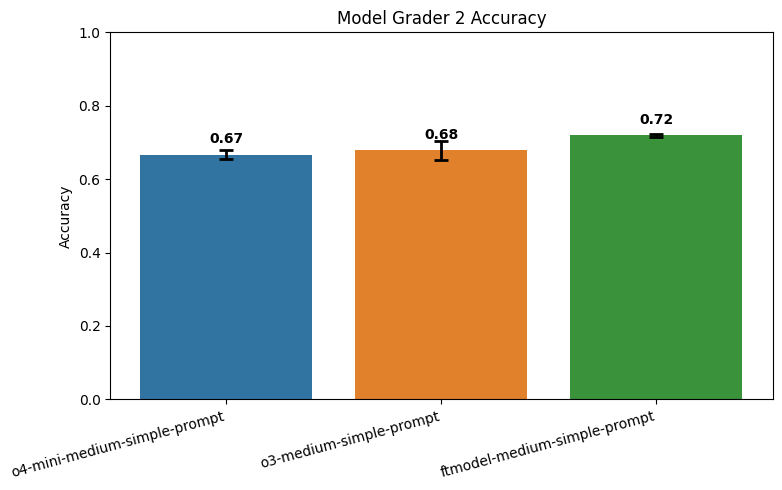

In [ ]:
avg_metrics_o4mini_medium_simple_prompt_model_grader_2, std_metrics_o4mini_medium_simple_prompt_model_grader_2 = average_and_std_metrics(metrics_o4mini_medium_simple_prompt_model_grader_2)
avg_metrics_o3_medium_simple_prompt_model_grader_2, std_metrics_o3_medium_simple_prompt_model_grader_2 = average_and_std_metrics(metrics_o3_medium_simple_prompt_model_grader_2)
avg_metrics_ftmodel_medium_simple_prompt_model_grader_2, std_metrics_ftmodel_medium_simple_prompt_model_grader_2 = average_and_std_metrics(metrics_ftmodel_medium_simple_prompt_model_grader_2)
model_metrics_avg = {
    "o4-mini-medium-simple-prompt": avg_metrics_o4mini_medium_simple_prompt_model_grader_2,
    "o3-medium-simple-prompt": avg_metrics_o3_medium_simple_prompt_model_grader_2,
    "ftmodel-medium-simple-prompt": avg_metrics_ftmodel_medium_simple_prompt_model_grader_2
}
model_metrics_std = {
    "o4-mini-medium-simple-prompt": std_metrics_o4mini_medium_simple_prompt_model_grader_2,
    "o3-medium-simple-prompt": std_metrics_o3_medium_simple_prompt_model_grader_2,
    "ftmodel-medium-simple-prompt": std_metrics_ftmodel_medium_simple_prompt_model_grader_2
}
plot_model_accuracies(model_metrics_avg, model_metrics_std, grader_title="Model Grader 2 Accuracy")

In [ ]:
# Print mistakes where the model did not get the correct answer (score < 1.0)
mistakes = [
    {"index": i, **res}
    for i, res in enumerate(predictions_ftmodel_medium_simple_prompt_model_grader_2[0])
    if res["score"] < 1.0
]

print(f"\nTotal mistakes: {len(mistakes)}")
for m in mistakes[5:10]:
    print(f"\n[Sample {m['index']}]")
    print(f"  Model prediction: {m['model_prediction']}")
    print(f"  Reference answer: {m['reference_answer']}")
    print(f"  Score: {m['score']}")


Total mistakes: 80

[Sample 5]
  Model prediction: carotid duplex ultrasound
  Reference answer: carotid doppler
  Score: 0.5525

[Sample 6]
  Model prediction: under fixation due to insufficient fixation time
  Reference answer: incomplete fixation
  Score: 0.5037037037037037

[Sample 7]
  Model prediction: acute rheumatic fever due to group a streptococcal pharyngitis mediated by type ii hypersensitivity
  Reference answer: acute rheumatic fever
  Score: 0.85

[Sample 8]
  Model prediction: exposure (open) method of burn treatment
  Reference answer: heterograft application with sutures to secure it in place and daily washes, but no dressing
  Score: 0.3031007751937985

[Sample 9]
  Model prediction: beta-lactamase production leading to enzymatic inactivation of ampicillin
  Reference answer: production of beta-lactamase enzyme
  Score: 0.7555555555555555


We see about a 5-point boost in accuracy after fine-tuning. Looking at the first few errors, the model tends to harshly penalize answers that are close but not clinically identical-like *carotid duplex ultrasound* vs. *carotid doppler*. It also dings longer answers, even when they’re correct, like *beta-lactamase production leading to enzymatic inactivation of ampicillin*.

o4-mini-medium-simple-prompt bin counts: [ 4. 15.  9.  7.  7.  4.  3.  5. 22. 24.]
ftmodel-medium-simple-prompt bin counts: [ 8. 15.  7.  3.  9.  7.  8.  4. 19. 20.]
Max bin count (y-axis): 24.0


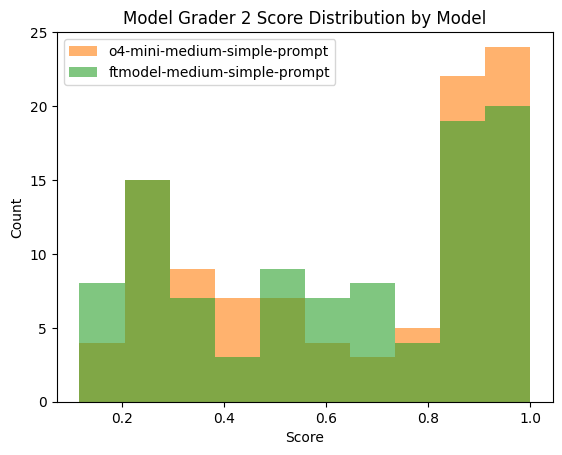

In [ ]:
scores_o4 = [p['score'] for p in predictions_o4mini_medium_simple_prompt_model_grader_2[0]]
scores_ft = [p['score'] for p in predictions_ftmodel_medium_simple_prompt_model_grader_2[0]]

# Determine common bins for both histograms
all_scores = scores_o4 + scores_ft
bins = plt.hist(all_scores, bins=10, alpha=0)[1]

# Plot histograms and capture the counts
counts_o4, _, _ = plt.hist(
    scores_o4,
    bins=bins,
    alpha=0.6,
    label='o4-mini-medium-simple-prompt'
)
counts_ft, _, _ = plt.hist(
    scores_ft,
    bins=bins,
    alpha=0.6,
    label='ftmodel-medium-simple-prompt'
)

plt.title("Model Grader 2 Score Distribution by Model")
plt.xlabel("Score")
plt.ylabel("Count")
plt.ylim(top=25)
plt.legend()

# Print the bin counts
print("o4-mini-medium-simple-prompt bin counts:", counts_o4)
print("ftmodel-medium-simple-prompt bin counts:", counts_ft)
print("Max bin count (y-axis):", max(max(counts_o4), max(counts_ft)))

Looking at the distruibution of scores, we observe that RFT helped shift the model’s predictions out of the mid-to-low score zone (0.4–0.5) and into the mid-to-high range (0.5–0.6). Since the grader emphasizes clinical similarity over lexical match, this shift reflects stronger medical reasoning-not just better phrasing-according to our *expert* grader. As observed in the 0.9-1.0 range, some verbosity crept in despite mitigations and slightly lowering scores throughout, though it often reflected more complete, semantically aligned answers. A future grader pass could better account for these cases.

Note that, because the earlier `combined_grader` was designed to reward lexical correctness, its accuracy didnʼt improve much-which is expected. That gap reinforces why validating your model grader is critical, and why you should monitor for reward-hacking. In our case, we used `o3` to spot-check grading behavior, but domain expert review is essential.

### Model's reasoning

Another important point in the analysis of the fine-tuned model are the reasoning summaries. The model may provide key information throughout these summaries, and exploring them to understand where the model fails can drive updates in the model's and the grader's system prompts. Below, we show examples of such chain of thought summaries that the model produced to show its way of answering the question:

In [ ]:
# Flatten the list of lists into a single list of dicts
predictions = {
    "o4-mini": predictions_o4mini_medium_simple_prompt_model_grader_2,
    "o3": predictions_o3_medium_simple_prompt_model_grader_2,
    "ftmodel": predictions_ftmodel_medium_simple_prompt_model_grader_2,
}

for model_name, predictions in predictions.items():
    all_preds = [item for sublist in predictions for item in sublist]
    reasoning_tokens = [p['reasoning_tokens_used'] for p in all_preds if 'reasoning_tokens_used' in p]
    mean_reasoning_tokens = np.mean(reasoning_tokens)
    print(f"Mean reasoning_tokens_used {model_name}: {mean_reasoning_tokens:.0f}")

Mean reasoning_tokens_used o4-mini: 424
Mean reasoning_tokens_used o3: 353
Mean reasoning_tokens_used ftmodel: 1820


The fine-tuned model spends more reasoning tokens to think through the question. Let's visualize an example thanks to the reasoning summaries.

In [ ]:
from IPython.display import Markdown, display
markdown_text = results_o4mini_model_grader_2[5]["summaries"]
display(Markdown(markdown_text))

Classifying staging type

The user provided a clinical scenario of a 35-year-old female with a 5 cm oral tumor and a 2 cm lymph node. They're asking how to stage it according to the TNM classification. This is a diagnosis query, so the correct answer type here is "diagnosis." Considering the tumor's size, it appears to be classified as T3 since it's greater than 4 cm. Thus, I think the staging might be Stage II, but I'll confirm that.


In [ ]:
markdown_text = results_ft_model_grader_2[5]["summaries"]
display(Markdown(markdown_text))

Clarifying T staging for cancers

I’m digging into T staging for head and neck cancers in the oral cavity. So, T1 applies to tumors 2 cm or less, T2 for those over 2 cm but not more than 4 cm, and T3 is for tumors over 4 cm. T4a indicates invasion into adjacent structures. The patient's tumor measures 5 cm, which is over 4 cm. I’m not sure if it fits T3 or T4a, since T4a involves additional invasiveness, not just size. Determining T and N staging

I’m looking at a 5 cm tumor in the oral cavity. It seems there’s no mention of invasion into adjacent structures, so I’m categorizing it as T3 due to its size. T4a usually means invasion into structures like bone or skin. According to the TNM classification, since I see no such invasion, T classification remains T3.

Moving on to N staging, I see there's a single lymph node of 2 cm on the same side; this fits the N1 classification for metastasis, as it’s less than 3 cm.


Base `o4-mini`'s reasoning gives a quick answer but doesn’t explain how it got there. It mentions the tumor size but doesn’t walk through the actual TNM rules, and it seems unsure about the result. On the other hand, the `finetuned model` is more thoughtful - breaking down the T and N staging step by step and explaining why each part applies. The latter seems more careful, and seems to have learnt to break down the case description even more.

### To push the scores further
Both the baseline `o3` and our fine-tuned `o4-mini` sometimes scored zero on the same samples-a red flag that the reference labels may be wrong. Before adding more compute, invest in data quality: have a domain expert relabel the noisy slice, analyze the model's reasoning, then tighten the grader prompt. Clean, trusted data and methodical updates almost always buys more accuracy than extra epochs.


---


## **Conclusion**

Weʼve looked at how to design graders that give `o4-mini` the kind of detailed feedback it needs during RFT. That signal is what helps the model actually learn and improve beyond the baseline. Model graders can be incredibly powerful for this-but only if theyʼre designed carefully. A sloppy grader or sloppy data can send the wrong signals and steer the model in the wrong direction.

You're now ready to apply reinforcement fine-tuning on your own models using the OpenAI API. Weʼre excited to see how you push the boundaries of reasoning and tool use with custom graders and smarter model behavior!

For troubleshooting or next steps, refer to the [OpenAI fine-tuning documentation](https://platform.openai.com/docs/guides/fine-tuning).

In [ ]:
from google.colab import userdata
from openai import OpenAI

# Retrieve the API key from Colab secrets
API_KEY = userdata.get('OPENAI_API_KEY')

# Initialize the OpenAI client
client = OpenAI(api_key=API_KEY)